# ODE-BVP's: Relaxation Methods
---

GENERAL PROBLEM: solve the 2-point boundary value problem

\begin{align}
  y''(x) = f(x, y(x), y'(x))
\end{align}

with boundary conditions

\begin{align}
  & \alpha_{1}y(0) + \beta_{1}y'(0) = g_{1}
  \\
  & \alpha_{2}y(L) + \beta_{2}y'(L) = g_{2}
\end{align}

Cases to consider:
- a. Dirichlet boundary conditions: $\beta_{1}=\beta_{2}=0$.
- b. Neumann boundary conditions: $\alpha_{1}=\beta_{2}=0$ or $\alpha_{2}=\beta_{1}=0$
- c. Mixed boundary conditions: any other combinations

IDEA: use finite differences as with direct methods. However rather than solve the system of equations directly, use the finite difference approximation to setup an iteration equation. Continue iterating until a fixed point ("steady state solution") is reached.

PRE-REQUISITES:
- ODE-IVP's
- ODE-BVP's: Direct Methods

REFERENCES:
- [1] DeVries and Hasbun, *A First Course in Computational Physics, 2nd edition*.
- [2] Garcia, *Numerical Methods for Physicists, 2nd edition*.
- [3] Burden and Faires, *Numerical Analysis, 7th edition*.
- [4] LeVeque, *Finite Difference Methods for Ordinary and Partial Differential Equations*.
- [5] Press et al, *Numerical Recipes, 3rd edition*.

## 1. Simple example using Jacobi's method

Consider the 2-point boundary value problem with Dirichlet boundary conditions for one degree of freedom

\begin{align}
  u''(x) = f(x)
  \quad\text{with}\quad
  u(0) = g_{1}
  \quad\text{and}\quad
  u(L) = g_{2}
\end{align}

where the source function $f(x)$ is given.

As before, we discretize the spatial domain into a vertex-centered grid with $N$ cells and $N+1$ grid points, evenly spaced between $x=0$ and $x=L$. The grid points are denoted $x_{j}$ where $j=0,\ldots,N$. The boundaries of the grid are given by $x_{0}=0$ and $x_{N}=L$. The grid spacing is denoted as $h$.

Next we discretize the grid functions by taking $u(x)\rightarrow u(x_{j}) \equiv u_{j}$ and $f(x)\rightarrow f(x_{j})\equiv f_{j}$.

Finally, we discretize the derivatives that appear in the ODE using a centered differencing scheme, yielding

\begin{align}
  \frac{u_{j-1} - 2u_{j} + u_{j+1}}{h^2} = f_{j}
  \quad,\quad
  j = 1,\ldots,N-1
\end{align}

with Dirichlet boundary conditions

\begin{align}
  & u_{0} = g_{1} \\
  & u_{N} = g_{2}
\end{align}

At this point, rather than solving the ODE by direct (matrix inversion) methods, instead we set up an iteration scheme. To do this, we first solve the finite difference equation above for u_{j}, which gives

\begin{align}
  u_{j} = \frac{1}{2}\left(u_{j+1} + u_{j-1} - h^2 f_{j}\right).
\end{align}

Next we write this as

\begin{align}
  u^{(n+1)}_{j} = \frac{1}{2}\left(u^{(n)}_{j+1} + u^{(n)}_{j-1} - h^2 f_{j}\right),
\end{align}

where the superscript index denotes the iteration number. This iteration scheme is called Jacobi's method.

### Exact solution

Recall the exact solution for the case with $L=1$ and $f(x)=x$ is given by 

\begin{align}
  u_\mathrm{exact}(x) = \tfrac{1}{6}x^3 + c_{1}x + c_{2}
\end{align}

where

\begin{align}
  & c_{1} = g_{2} - g_{1} - \frac{1}{6} \\
  & c_{2} = g_{2}
\end{align}

### CODE:

In [1]:
import numpy as np
from numpy import linalg as la
%matplotlib notebook
import matplotlib.pyplot as plt
import time

In [2]:
# plot function
def uplot(iterStep, iterErr, X, U, Uex, xmin, xmax, ymin, ymax, axis, fig):
    axis.cla()                   #clear previous plot
    axis.set_xlim(xmin,xmax)     #set x limits of plot
    axis.set_ylim(ymin,ymax)     #set y limits of plot
    axis.set_xlabel('x')         #set x-axis label
    axis.set_ylabel('u(x)')      #set y-axis label
    axis.set_title('iteration %.2f, estimated error %f' % (iterStep, iterErr)) #set title 
    axis.plot(X, U, label='numerical') #plot u vs x
    axis.plot(X, Uex, label='exact') #plot u_exact vs x
    axis.legend(loc='lower right')
    fig.canvas.draw()            #redraw figure
    time.sleep(0.05)             #pause

In [3]:
# source function
def f(x):
    return x

In [4]:
# exact solution
def exact(x, g1, g2):
    c1 = g2 - g1 - 1/6
    c2 = g1
    return (1/6)*x**3 + c1*x + c2

In [5]:
# Jacobi iterator
def jacobi(h, uold, rhs):
    unew = np.copy(uold)
    unew[1:-1] = 0.5*(uold[2:] + uold[0:-2] - h*h*rhs[1:-1])
    return unew

In [6]:
# solve simple bvp    
def bvp(xL, xR, N, iterator, tol, maxiter):
    """
    INPUT:
    xL = left boundary
    xR = right boundary
    N = total number of spatial grid points
    iterator = handle of function used to iterate solutions
    tol = target tolerance
    maxiter = max number of iterations, in case tolerance is never reached
    """
    # set boundary conditions
    g1 = 2.0
    g2 = 5.0

    # set spatial grid
    xmin = xL   # left boundary
    xmax = xR   # right boundary
    h = (xmax-xmin)/N # grid spacing
    x = np.linspace(xmin, xmax, N+1)

    # create figure
    fig = plt.figure(figsize=(7, 5), dpi=100)
    ax1 = fig.add_subplot(111)

    # initialize grid function arrays
    u = 2*np.ones_like(x)
    rhs = f(x)
    uex = exact(x, g1, g2)
    ymin = np.amin(uex)
    ymax = np.amax(uex)

    # solve
    for n in range(maxiter):
        # copy solution from previous time step
        un = u.copy()

        # update solution at interior points
        u = iterator(h, un, rhs)

        # update solution at boundary points
        u[ 0] = g1  #u at x=xL
        u[-1] = g2  #u at x=xR
        
        # calculate and check relative error
        #relerr = la.norm(u - un, 2)/la.norm(u, 2)
        #if relerr <= tol:
        #    break

        # calculate and check absolute error
        abserr = la.norm(uex - u, 2)/la.norm(uex, 2)
        if abserr <= tol:
            break

        #plot configuration
        uplot(n, abserr, x, u, uex, xmin, xmax, ymin, ymax, ax1, fig)

<IPython.core.display.Javascript object>


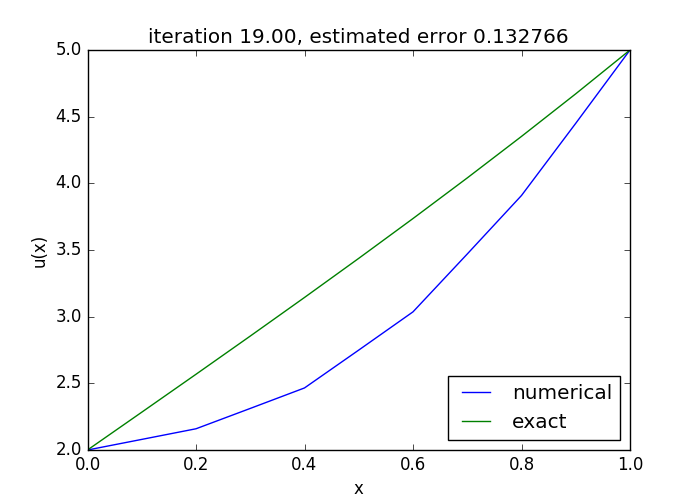

In [7]:
bvp(0, 1, 10, jacobi, 1e-3, 20)

## 2. Gauss-Seidel method

The Jacobi method updates the solution over the entire grid, using only values from the previous iteration. Instead we might use updated values as soon as they become available. This leads to the iteration scheme


\begin{align}
  u^{(n+1)}_{j} = \frac{1}{2}\left(u^{(n)}_{j+1} + u^{(n+1)}_{j-1} - h^2 f_{j}\right),
\end{align}

assuming that the solution is updated from left to right. When calculating the solution $u^{(n+1)}_{j}$, the solution at the trailing grid point, $j-1$, is taken from the current iteration instead of the previous iteration. The only thing that need to be modified in the above code is the iterator module.

In [8]:
# Gauss-Seidel iterator
def gauss_seidel(h, uold, rhs):
    unew = np.copy(uold)
    N = len(uold[:])
    for i in range(1,N-1):
        unew[i] = 0.5*(uold[i+1] + unew[i-1] - h*h*rhs[i])
    return unew

<IPython.core.display.Javascript object>


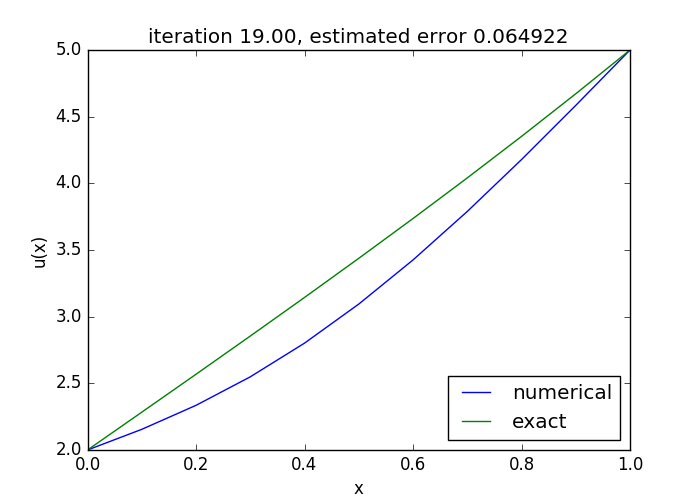

In [9]:
bvp(0, 1, 10, gauss_seidel, 1e-3, 20)

## 3. Successive Over-Relaxation (SOR)

We can generalize Gauss-Seidel by the weighted iteration equation 

\begin{align}
  u^{(n+1)}_{j} =
  (1 - \omega)u^{(n)}_{j}
  + \frac{\omega}{2}\left(u^{(n+1)}_{j-1} + u^{(n)}_{j+1} - h^2 f_{j}\right).
\end{align}

Note that when $\omega=1$, this reduces to Gauss-Seidel. When $\omega<1$, the iteration under corrects compared to Gauss-Seidel. As a result, convergence to the actual solution is slowed. This situation is called "under relaxed". In contrast, when $\omega>1$ the system is "over relaxed", and convergence to the true solution is sped up. However, more is not always better. It can be shown that the scheme is unstable (no convergence) if $\omega>2$. Therefore, the optimal value for $\omega$ is somewhere between 1 and 2. In practice, a sufficiently optimal value of $\omega$ is determined by trial and error. 

In [10]:
# SOR iterator
def sor(h, uold, rhs):
    omega = 1.75 #for stable over-relaxation: 1.0 < omega < 2.0
    unew = np.copy(uold)
    N = len(uold[:])
    for i in range(1,N-1):
        unew[i] = (1 - omega)*uold[i] + omega*0.5*(uold[i+1] + unew[i-1] - h*h*rhs[i])
    return unew

<IPython.core.display.Javascript object>


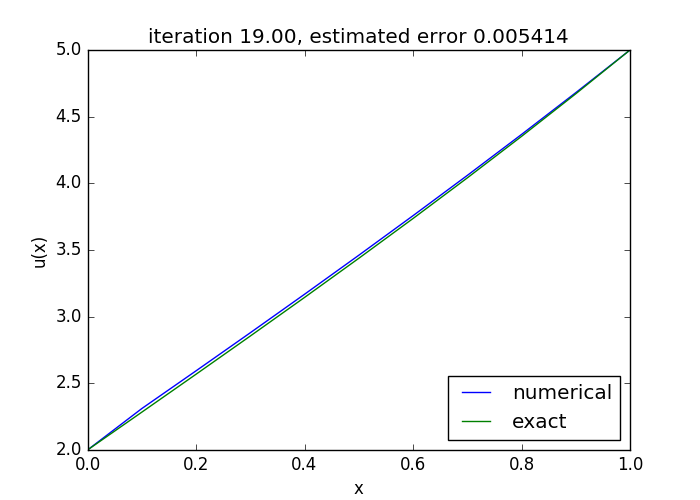

In [11]:
bvp(0, 1, 10, sor, 1e-3, 20)

## 4. More general linear example

Consider the more general 2-pt boundary value problem

\begin{align}
  u''(x) + p(x) u'(x) + q(x) u(x) = f(x)
  \quad\text{with}\quad
  u(0) = g_{1}
  \quad\text{and}\quad
  u(L) = g_{2}.
\end{align}

After discretizing, this yields the iteration equations

\begin{align}
  & u^{(n+1)}_{j} = \frac{1}{2(2 - h^2 q_{j})}\left[
  (2 + h p_{j})u^{(n)}_{j+1} 
  + (2 - h p_{j})u^{(n)}_{j-1} 
  - 2h^2 f_{j}\right]
  \quad\quad\text{(Jacobi)}
  \\
  & u^{(n+1)}_{j} = \frac{1}{2(2 - h^2 q_{j})}\left[
  (2 + h p_{j})u^{(n)}_{j+1} 
  + (2 - h p_{j})u^{(n+1)}_{j-1} 
  - 2h^2 f_{j}\right]
  \quad\quad\text{(Gauss-Seidel)}
  \\
  & u^{(n+1)}_{j} = (1 - \omega)u^{(n)}_{j}
  + \frac{\omega}{2(2 - h^2 q_{j})}\left[
  (2 + h p_{j})u^{(n)}_{j+1} 
  + (2 - h p_{j})u^{(n+1)}_{j-1} 
  - 2h^2 f_{j}\right]
  \quad\quad\text{(SOR)}
\end{align}

### Example

[Burden and Faires, example 2, section 11.1]

Recall the following BVP:

\begin{align}
  u''(x) = -\frac{2}{x}u'(x) + \frac{2}{x^2}u(x) + \frac{\sin(\ln{x})}{x^2}
  \quad,\quad
  u(1) = 1
  \quad,\quad
  u(2) = 2
\end{align}

with exact solution

\begin{align}
  u_\mathrm{exact}(x) = c_{1}x + \frac{c_{2}}{x^2} - \frac{3}{10}\sin(\ln{x}) - \frac{1}{10}\cos(\ln{x})
\end{align}

where

\begin{align}
  c_{2} = \frac{1}{70}\left[8 - 12\sin(\ln{2}) - 4\cos(\ln{2})\right]
  \approx -0.03920701320
\end{align}

and 

\begin{align}
  c_{1} = \frac{11}{10} - c_{2} 
  \approx 1.1392070132
\end{align}

### CODE:

In [12]:
# plot function
def uplotGL(iterStep, iterErr, X, U, Uex, xmin, xmax, ymin, ymax, axis, fig):
    axis.cla()                   #clear previous plot
    axis.set_xlim(xmin,xmax)     #set x limits of plot
    axis.set_ylim(ymin,ymax)     #set y limits of plot
    axis.set_xlabel('x')         #set x-axis label
    axis.set_ylabel('u(x)')      #set y-axis label
    axis.set_title('iteration %.2f, estimated error %f' % (iterStep, iterErr)) #set title 
    axis.plot(X, U, label='numerical') #plot u vs x
    axis.plot(X, Uex, label='exact') #plot u_exact vs x
    axis.legend(loc='lower right')
    fig.canvas.draw()            #redraw figure
    time.sleep(0.05)             #pause

In [13]:
# rhs function
def fGL(x):
    return np.sin(np.log(x))/(x*x)

In [14]:
# lhs functions
def pGL(x):
    return 2./x

def qGL(x):
    return -2./(x*x)

In [15]:
# exact solution
def exactGL(x):
    c2 = (1./70.)*(8. - 12.*np.sin(np.log(2.)) - 4*np.cos(np.log(2.)))
    c1 = 11./10. - c2
    return c1*x + c2/(x*x) - (3./10.)*np.sin(np.log(x)) - (1./10.)*np.cos(np.log(x)) 

In [16]:
# SOR iterator for general, linear, 2nd-order bvp
def sorGL(h, uold, p, q, rhs):
    omega = 1.5 #for stable over-relaxation: 1.0 < omega < 2.0
    unew = np.copy(uold)
    N = len(uold[:])
    for i in range(1,N-1):
        unew[i] = (1 - omega)*uold[i] \
        + omega/(2*(2 - h*h*q[i]))* \
        ((2 + h*p[i])*uold[i+1] + (2 - h*p[i])*unew[i-1] - 2*h*h*rhs[i])
    return unew

In [17]:
# solve general, linear, 2nd-order bvp    
def bvpGL(xL, xR, N, iterator, tol, maxiter):
    """
    INPUT:
    xL = left boundary
    xR = right boundary
    N = total number of spatial grid points
    iterator = handle of function used to iterate solutions
    tol = target tolerance
    maxiter = max number of iterations, in case tolerance is never reached
    """
    # set boundary conditions
    g1 = 1.0
    g2 = 2.0

    # set spatial grid
    xmin = xL   # left boundary
    xmax = xR   # right boundary
    h = (xmax-xmin)/N # grid spacing
    x = np.linspace(xmin, xmax, N+1)

    # create figure
    fig = plt.figure(figsize=(7, 5), dpi=100)
    ax1 = fig.add_subplot(111)

    # initialize grid function arrays
    u = 0*np.ones_like(x)
    p = pGL(x)
    q = qGL(x)
    f = fGL(x)
    uex = exactGL(x)
    ymin = np.amin(uex)
    ymax = np.amax(uex)

    # solve
    for n in range(maxiter):
        # copy solution from previous time step
        un = u.copy()

        # update solution at interior points
        u = iterator(h, un, p, q, f)

        # update solution at boundary points
        u[ 0] = g1  #u at x=xL
        u[-1] = g2  #u at x=xR
        
        # calculate and check relative error
        #relerr = la.norm(u - un, 2)/la.norm(u, 2)
        #if relerr <= tol:
        #    break

        # calculate and check absolute error
        abserr = la.norm(uex - u, 2)/la.norm(uex, 2)
        if abserr <= tol:
            break

        #plot configuration
        uplotGL(n, abserr, x, u, uex, xmin, xmax, ymin, ymax, ax1, fig)

<IPython.core.display.Javascript object>


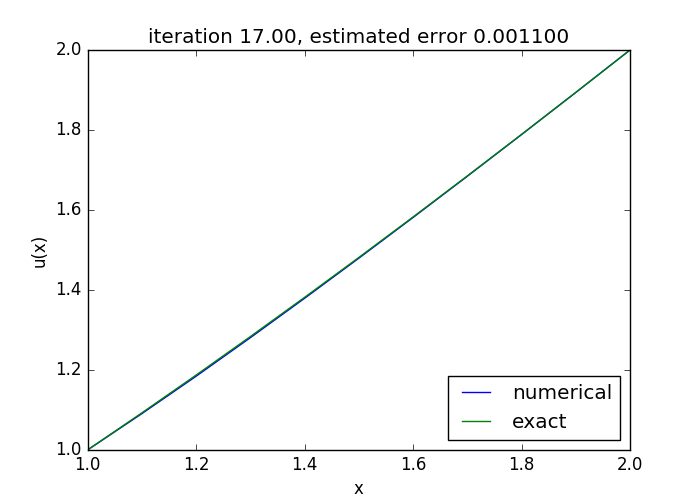

In [18]:
bvpGL(1, 2, 10, sorGL, 1e-3, 20)

## 5. Non-linear example

Relaxation methods can easily be extended to non-linear problems. The main idea stays the same: discretize the ODE using finite differences, solve for the grid function at the current grid point, convert the equation into an iteration equation (Jacobi, Gauss-Seidel, or SOR).

Let's write a general 2nd-order, non-linear, ODE-BVP as

\begin{align}
  y''(x) = f(x, y(x), y'(x))
\end{align}

with 

\begin{align}
  & \alpha_{1}y(a) + \beta_{1}y'(a) = g_{1} \\
  & \alpha_{2}y(b) + \beta_{2}y'(b) = g_{2}.
\end{align}

For simplicity, here we will only consider Dirichlet boundary conditions

\begin{align}
  & y(a) = g_{1} \\
  & y(b) = g_{2}.
\end{align}

Discretizing and re-arranging the ODE above leads to

\begin{align}
  u_{i} = \frac{1}{2}\left[u_{i+1} + u_{i-1} 
  - h^2f\left(x_{i}, u_{i}, \frac{u_{i+1} - u_{i-1}}{2h}\right)\right]
\end{align}

which can then be used to construct an iteration formula

\begin{align}
  & u^{(n+1)}_{i} = \frac{1}{2}\left[u^{(n)}_{i+1} + u^{(n)}_{i-1} 
  - h^2f\left(x_{i}, u^{(n)}_{i}, \frac{u^{(n)}_{i+1} - u^{(n)}_{i-1}}{2h}\right)\right]
  \quad\quad\text{(Jacobi)}
  \\
  & u^{(n+1)}_{i} = \frac{1}{2}\left[u^{(n)}_{i+1} + u^{(n+1)}_{i-1} 
  - h^2f\left(x_{i}, u^{(n)}_{i}, \frac{u^{(n)}_{i+1} - u^{(n+1)}_{i-1}}{2h}\right)\right]
  \quad\quad\text{(Gauss-Seidel)}
  \\
  &u^{(n+1)}_{i} = (1 - \omega)u^{(n)}_{i}
  + \frac{\omega}{2}\left[u^{(n)}_{i+1} + u^{(n)}_{i-1} 
  - h^2f\left(x_{i}, u^{(n)}_{i}, \frac{u^{(n)}_{i+1} - u^{(n)}_{i-1}}{2h}\right)\right]
  \quad\quad\text{(SOR)}
\end{align}

### Example

[Burden and Faires, example 1, section 11.2]

Consider the following BVP:

\begin{align}
  u''(x) = \frac{1}{8}(32 + 2x^3 - u(x)u'(x))
  \quad,\quad
  u(1) = 17
  \quad,\quad
  u(3) = \frac{43}{3}
\end{align}

with exact solution

\begin{align}
  u_\mathrm{exact}(x) = x^2 + \frac{16}{x}
\end{align}

### CODE:

In [19]:
# plot function
def uplotNL(iterStep, iterErr, X, U, Uex, xmin, xmax, ymin, ymax, axis, fig):
    axis.cla()                   #clear previous plot
    axis.set_xlim(xmin,xmax)     #set x limits of plot
    axis.set_ylim(ymin,ymax)     #set y limits of plot
    axis.set_xlabel('x')         #set x-axis label
    axis.set_ylabel('u(x)')      #set y-axis label
    axis.set_title('iteration %.2f, estimated error %f' % (iterStep, iterErr)) #set title 
    axis.plot(X, U, label='numerical') #plot u vs x
    axis.plot(X, Uex, label='exact') #plot u_exact vs x
    axis.legend(loc='upper right')
    fig.canvas.draw()            #redraw figure
    time.sleep(0.05)             #pause

In [20]:
# rhs function
def fNL(x, u, dx):
    f = np.zeros_like(u)
    f[0] = 0.125*(32 + 2*x[0]*x[0]*x[0] - u[0]*(u[0] - u[-1])/dx)
    f[1:-1] = 0.125*(32 + 2*x[1:-1]*x[1:-1]*x[1:-1] - u[1:-1]*(u[2:] - u[0:-2])/(2*dx))
    f[-1] = 0.125*(32 + 2*x[-1]*x[-1]*x[-1] - u[-1]*(u[-1] - u[-2])/dx)
    return f

In [21]:
# exact solution
def exactNL(x):
    return x*x + 16.0/x 

In [22]:
# SOR iterator for non-linear, 2nd-order bvp
def sorNL(h, uold, f):
    omega = 1.5 #for stable over-relaxation: 1.0 < omega < 2.0
    unew = np.copy(uold)
    N = len(uold[:])
    for i in range(1,N-1):
        unew[i] = (1 - omega)*uold[i] \
        + 0.5*omega*(uold[i+1] + unew[i-1] - h*h*f[i])
    return unew

In [23]:
# solve non-linear, 2nd-order bvp    
def bvpNL(xL, xR, N, iterator, tol, maxiter):
    """
    INPUT:
    xL = left boundary
    xR = right boundary
    N = total number of spatial grid points
    iterator = handle of function used to iterate solutions
    tol = target tolerance
    maxiter = max number of iterations, in case tolerance is never reached
    """
    # set boundary conditions
    g1 = 17.0
    g2 = 43.0/3.0

    # set spatial grid
    xmin = xL   # left boundary
    xmax = xR   # right boundary
    h = (xmax-xmin)/N # grid spacing
    x = np.linspace(xmin, xmax, N+1)

    # create figure
    fig = plt.figure(figsize=(7, 5), dpi=100)
    ax1 = fig.add_subplot(111)

    # initialize grid function arrays
    u = 0*np.ones_like(x)
    uex = exactNL(x)
    ymin = np.amin(uex)
    ymax = np.amax(uex)

    # solve
    for n in range(maxiter):
        # copy solution from previous time step
        un = u.copy()

        # update solution at interior points
        u = iterator(h, un, fNL(x, un, h))

        # update solution at boundary points
        u[ 0] = g1  #u at x=xL
        u[-1] = g2  #u at x=xR
        
        # calculate and check relative error
        #relerr = la.norm(u - un, 2)/la.norm(u, 2)
        #if relerr <= tol:
        #    break

        # calculate and check absolute error
        abserr = la.norm(uex - u, 2)/la.norm(uex, 2)
        if abserr <= tol:
            break

        #plot configuration
        uplotNL(n, abserr, x, u, uex, xmin, xmax, ymin, ymax, ax1, fig)

<IPython.core.display.Javascript object>


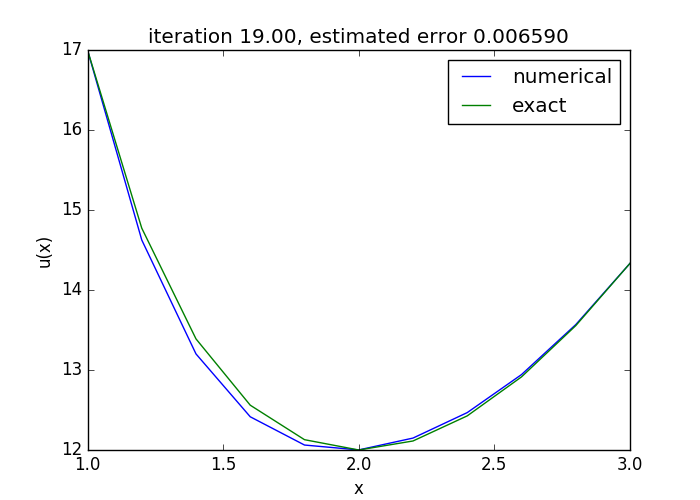

In [24]:
bvpNL(1, 3, 10, sorNL, 1e-3, 20)